# === readme ===
descrip: regrid 0.1 and 1 deg resolution POP original grids and create weight files

update history: <br>
v1.0 DL 2020Jul24

extra notes: <br>
use xgcm and xesmf for earth data: https://earth-env-data-science.github.io/lectures/working_with_gcm_data.html <br>

xesmf error "ValueError: ESMC_FieldRegridStoreFile() failed with rc = 506. Please check the log files (named "*ESMF_LogFile")." issue: https://github.com/JiaweiZhuang/xESMF/issues/78 <br>

xesmf regriding example:https://xesmf.readthedocs.io/en/latest/notebooks/Curvilinear_grid.html <br>

reuse the weight file created by xesmf: 
https://xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html <br>

demo of plotting CESM POP sea ice: https://gist.github.com/bradyrx/aee079f8494b084a5c56f7eaf83c8cef <br>

#  === import modules ===

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import xesmf as xe

# === regrid 1 deg resoltion POP ===

In [2]:
infile_LR = ('/ihesp/archive/LR/b.e13.B1950C5.ne30_g16.ihesp24_1950cntl.002/ocn/hist/'
             'b.e13.B1950C5.ne30_g16.ihesp24_1950cntl.002.pop.h.nday1.0066-07-01.nc')
ds_LR = xr.open_dataset(infile_LR)
print(ds_LR)
print('==========================')
sst_LR_raw = ds_LR.SST.isel(time=0) # variable to be regrided
print(sst_LR_raw)
print('===========================')

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 384, nlon: 320, time: 31, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * time                (time) object 0066-07-02 00:00:00 ... 0066-08-01 00:00:00
  * z_t                 (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 ... 500004.7 525000.94
  * z_w_top             (z_w_top) float32 0.0 1000.0 ... 500004.7 525000.94
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 ... 525000.94 549999.06
    ULONG               (nlat, nlon) float64 ...
    ULAT                (nlat, nlon) float64 ...
    TLONG               (nlat, nlon) float64 ...
    TLAT                (nlat, nlon) float64 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound          (time, d2) object ...
    dz                  (z_t) float32 ...
    dzw                 (z_w

### prepare input and output grids

In [3]:
# use the POP grid file instead of the CESM POP nc files for input grids
# the grid in the CESM POP nc files seems to have strange format which can not 
# be understood by xesmf, DL 2020Jul24

# === input grids ===
POPgridsFile_gx1v6 = '/ihesp/user/dapengli/Projects4iHESP/Project_MLD_2020May28/DataAnalysis/raw_data/POPgrids/POPgrids_gx1v6_2020Jun29.nc'
ds_grid_gx1v6 = xr.open_dataset(POPgridsFile_gx1v6)
print(ds_grid_gx1v6)
print('========================')
print(ds_grid_gx1v6.TLAT.values)
print('========================')
print(ds_grid_gx1v6.TLONG.values)
print('========================')
ds_grid_gx1v6 = ds_grid_gx1v6.rename({'TLONG': 'lon', 'TLAT': 'lat'}) # rn: rename
print(ds_grid_gx1v6)
print('========================')
# ====================

# === output grids ===
# create target grid, 1x1 degree rectilinear
ds_LR_out = xe.util.grid_global(1, 1)
print(ds_LR_out)
print('========================')
# ====================

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
    TLAT         (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    ULAT         (nlat, nlon) float64 ...
    ULONG        (nlat, nlon) float64 ...
    DXT          (nlat, nlon) float64 ...
    DYT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    KMT          (nlat, nlon) int32 ...
    REGION_MASK  (nlat, nlon) int32 ...
    dz           (z_t) float64 ...
Attributes:
    lateral_dims:         [384 320]
    vertical_dims:        60
    vert_grid_file:       gx1v7_vert_grid
    horiz_grid_fname:     inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402

### regrid data 

In [4]:
%%time
# === create weight file ===
regridder = xe.Regridder(ds_grid_gx1v6, ds_LR_out, method='bilinear', periodic=True,
                        filename='bilinear_POPgx1v6_1x1degGlobal_periodic_2020Jul27.nc')
# you can reuse weight file after the weight file is generated. 
# see https://xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html
# regridder2 = xe.Regridder(ds_in, ds_out, 'bilinear', reuse_weights=True)
# dr_out2 = regridder2(ds_in['data4D'])
regridder  # print basic regridder information.

Create weight file: bilinear_POPgx1v6_1x1degGlobal_periodic_2020Jul27.nc
CPU times: user 8.27 s, sys: 479 ms, total: 8.75 s
Wall time: 8.97 s


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_POPgx1v6_1x1degGlobal_periodic_2020Jul27.nc 
Reuse pre-computed weights? False 
Input grid shape:           (384, 320) 
Output grid shape:          (180, 360) 
Output grid dimension name: ('y', 'x') 
Periodic in longitude?      True

In [5]:
# === actual regriding ===
sst_LR_raw = sst_LR_raw.where(ds_grid_gx1v6.KMT>0,np.nan) # mask land with NaN
sst_LR_rgd = regridder(sst_LR_raw) # rgd: regrid
print(sst_LR_rgd)
print('========================')

<xarray.DataArray 'SST' (y: 180, x: 360)>
array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ...,
       [-1.68241548, -1.68252195, -1.68263063, ..., -1.68210838,
        -1.6822088 , -1.68231113],
       [-1.678212  , -1.67830165, -1.67838964, ..., -1.67793339,
        -1.67802783, -1.67812071],
       [-1.67598422, -1.67604552, -1.67610631, ..., -1.67579753,
        -1.67586021, -1.67592244]])
Coordinates:
    time     object 0066-07-02 00:00:00
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
Dimensions without coordinates: y, x
Attributes:
    regrid_method:  bilinear


Text(0.5, 1.0, 'regrided grids')

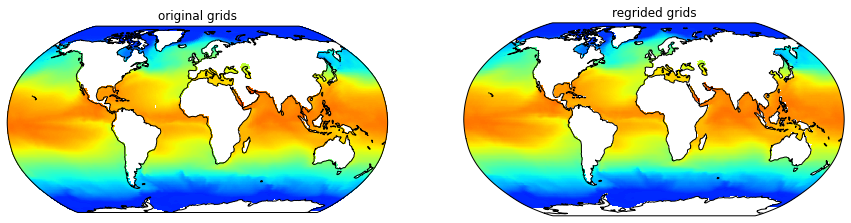

In [6]:
# === plot to compare raw and regrided data ===
# proj = cartopy.crs.Mollweide(central_longitude=180)
proj = ccrs.Robinson(central_longitude=0)
pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121,projection=proj)
subplt1=ax1.pcolormesh(sst_LR_raw.TLONG, sst_LR_raw.TLAT, sst_LR_raw,
                       vmin=-10,vmax=40,transform=pc,cmap='jet')
ax1.coastlines()
ax1.set_title('original grids')

ax2 = fig.add_subplot(122,projection=proj)
subplt2=ax2.pcolormesh(sst_LR_rgd.lon, sst_LR_rgd.lat, sst_LR_rgd,
                       vmin=-10,vmax=40,transform=pc,cmap='jet')
ax2.coastlines()
ax2.set_title('regrided grids')

# === regrid 0.1 deg resolution POP ===

In [7]:
infile_HR = ('/ihesp/archive/HRMIP/B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013/ocn/hist/'
             'B.E.13.B1950TRC5.ne120_t12.cesm-ihesp-1950-2050.013.pop.h.nday1.2050-09-01.nc')
ds_HR = xr.open_dataset(infile_HR)
print(ds_HR)
print('=========================')

sst_HR_raw = ds_HR.SST.isel(time=0) # variable to be regrided
print(sst_HR_raw)
print('===========================')

<xarray.Dataset>
Dimensions:             (d2: 2, nlat: 2400, nlon: 3600, time: 30, z_t: 62, z_t_150m: 15, z_w: 62, z_w_bot: 62, z_w_top: 62)
Coordinates:
  * time                (time) object 2050-09-02 00:00:00 ... 2050-10-01 00:00:00
  * z_t                 (z_t) float32 500.0 1500.0 ... 562499.06 587499.06
  * z_t_150m            (z_t_150m) float32 500.0 1500.0 ... 13500.0 14500.0
  * z_w                 (z_w) float32 0.0 1000.0 2000.0 ... 549999.06 574999.06
  * z_w_top             (z_w_top) float32 0.0 1000.0 ... 549999.06 574999.06
  * z_w_bot             (z_w_bot) float32 1000.0 2000.0 ... 574999.06 599999.06
    ULONG               (nlat, nlon) float64 ...
    ULAT                (nlat, nlon) float64 ...
    TLONG               (nlat, nlon) float64 ...
    TLAT                (nlat, nlon) float64 ...
Dimensions without coordinates: d2, nlat, nlon
Data variables:
    time_bound          (time, d2) object ...
    dz                  (z_t) float32 ...
    dzw                 (z_w)

### prepare input and output grids

In [2]:
# use the POP grid file instead of the CESM POP nc files for input grids
# the grid in the CESM POP nc files seems to have strange format which can not 
# be understood by xesmf, DL 2020Jul24

# === input grids ===
POPgridsFile_tx01v2 = '/ihesp/user/dapengli/Projects4iHESP/Project_MLD_2020May28/DataAnalysis/raw_data/POPgrids/POPgrids_tx0.1v2_2020Jun29.nc'
ds_grid_tx01v2 = xr.open_dataset(POPgridsFile_tx01v2)
print(ds_grid_tx01v2)
print('========================')
print(ds_grid_tx01v2.TLAT.values)
print('========================')
print(ds_grid_tx01v2.TLONG.values)
print('========================')
ds_grid_tx01v2 = ds_grid_tx01v2.rename({'TLONG': 'lon', 'TLAT': 'lat'}) # rn: rename
print(ds_grid_tx01v2)
print('========================')
# ====================

# === output grids ===
# create target grid
# ds_HR_out = xr.Dataset({'lat': (['lat'], np.arange(-78, 78.1, 0.1)),
#                      'lon': (['lon'], np.arange(-180, 180, 0.1))})
ds_HR_out = xr.Dataset({'lat': (['lat'], np.arange(-89.5, 89.5, 0.1)),
                     'lon': (['lon'], np.arange(-180, 180, 0.1))})
# ds_HR_out = xe.util.grid_global(0.1, 0.1)
# -78, -79 is southest point for xesmf, DL 2020Jul27
print(ds_HR_out)
print('========================')
# ====================

<xarray.Dataset>
Dimensions:      (nlat: 2400, nlon: 3600, z_t: 62, z_w: 62, z_w_bot: 62)
Coordinates:
    TLAT         (nlat, nlon) float64 ...
    TLONG        (nlat, nlon) float64 ...
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.625e+05 5.875e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    ULAT         (nlat, nlon) float64 ...
    ULONG        (nlat, nlon) float64 ...
    DXT          (nlat, nlon) float64 ...
    DYT          (nlat, nlon) float64 ...
    TAREA        (nlat, nlon) float64 ...
    KMT          (nlat, nlon) int32 ...
    REGION_MASK  (nlat, nlon) int32 ...
    dz           (z_t) float64 ...
Attributes:
    lateral_dims:       [2400 3600]
    vertical_dims:      62
    vert_grid_file:     tx0.1v3_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/tx0.1v2/grid/horiz_grid_200709.ieeer

### regrid data

In [ ]:
%%time
# === create weight file ===
regridder2 = xe.Regridder(ds_grid_tx01v2, ds_HR_out, method='bilinear', periodic=True,
                          filename='test_2020Jul27.nc')
#             filename='bilinear_POPtx01v2_0.1x0.1deg_78S-78N_periodic_2020Jul27.nc')
# regridder2 = xe.Regridder(ds_grid_tx01v2, ds_HR_out, method='bilinear', periodic=True, 
#                          reuse_weights=True)
# you can reuse weight file after the weight file is generated. 
# see https://xesmf.readthedocs.io/en/latest/notebooks/Reuse_regridder.html
# regridder2 = xe.Regridder(ds_in, ds_out, 'bilinear', reuse_weights=True)
# dr_out2 = regridder2(ds_in['data4D'])
regridder2  # print basic regridder information.

Create weight file: test_2020Jul27.nc


In [10]:
# === actual regriding ===
sst_HR_raw = sst_HR_raw.where(ds_grid_tx01v2.KMT>0,np.nan) # mask land with NaN
sst_HR_rgd = regridder2(sst_HR_raw) # rgd: regrid
print(sst_HR_raw)
print('========================')
print(sst_HR_rgd)
print('========================')

<xarray.DataArray 'SST' (nlat: 2400, nlon: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    time     object 2050-09-02 00:00:00
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
    lat      (nlat, nlon) float64 -78.47 -78.47 -78.47 ... 62.34 62.34 62.34
    lon      (nlat, nlon) float64 250.1 250.2 250.2 250.3 ... 250.0 250.0 250.0
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Surface Potential Temperature
    units:         degC
    grid_loc:      2110
    cell_methods:  time: mean
<xarray.DataArray 'SST' (lat: 1561, lon: 3600)>
array([[       nan,        nan,        nan, ...,        nan,      

Text(0.5, 1.0, 'regrided grids')

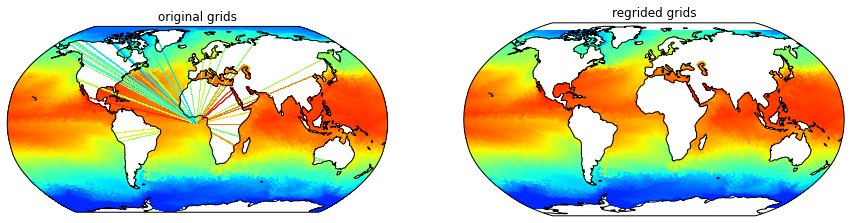

In [11]:
# === plot to compare raw and regrided data ===
# proj = cartopy.crs.Mollweide(central_longitude=180)
proj = ccrs.Robinson(central_longitude=0)
pc = ccrs.PlateCarree()

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121,projection=proj)
subplt1=ax1.pcolormesh(sst_HR_raw.TLONG, sst_HR_raw.TLAT, sst_HR_raw,
                       vmin=-10,vmax=40,transform=pc,cmap='jet')
ax1.coastlines()
ax1.set_title('original grids')

ax2 = fig.add_subplot(122,projection=proj)
subplt2=ax2.pcolormesh(sst_HR_rgd.lon, sst_HR_rgd.lat, sst_HR_rgd,
                       vmin=-10,vmax=40,transform=pc,cmap='jet')
ax2.coastlines()
ax2.set_title('regrided grids')